In [1]:
from IPython.display import display
from ipywidgets import FloatProgress
import pickle, gzip
import numpy as np
import copy

import sys
sys.path.append('../src')

import neuralnetworkclassifier as nnc
import mlutils as ml
import perturb as per

import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
plt.style.use('seaborn-whitegrid')

In [2]:
!wget http://deeplearning.net/data/mnist/mnist.pkl.gz

--2019-11-12 14:36:09--  http://deeplearning.net/data/mnist/mnist.pkl.gz
Resolving deeplearning.net (deeplearning.net)... 132.204.26.28
Connecting to deeplearning.net (deeplearning.net)|132.204.26.28|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16168813 (15M) [application/x-gzip]
Saving to: ‘mnist.pkl.gz.5’

mnist.pkl.gz.5      100%[===================>]  15.42M  4.84MB/s    in 3.2s    

2019-11-12 14:36:13 (4.84 MB/s) - ‘mnist.pkl.gz.5’ saved [16168813/16168813]



In [2]:
with gzip.open('mnist.pkl.gz', 'rb') as f:
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')

Xtrain = train_set[0].reshape(-1, 1, 28, 28)
Ttrain = train_set[1].reshape((-1, 1))

Xtest  = test_set[0].reshape(-1, 1, 28, 28)
Ttest  = test_set[1].reshape((-1, 1))

Xvalid = valid_set[0].reshape(-1, 1, 28, 28)
Tvalid = valid_set[1].reshape((-1, 1))

print(Xtrain.shape, Ttrain.shape, Xtest.shape, Ttest.shape, Xvalid.shape, Tvalid.shape)

(50000, 1, 28, 28) (50000, 1) (10000, 1, 28, 28) (10000, 1) (10000, 1, 28, 28) (10000, 1)


In [3]:
nnet = nnc.NeuralNetwork_Convolutional(n_channels_in_image=Xtrain.shape[1],
                                       image_size=Xtrain.shape[2],
                                       n_units_in_conv_layers=[10], 
                                       kernels_size_and_stride=[(7, 3)],
                                       n_units_in_fc_hidden_layers=[],
                                       classes=np.unique(Ttrain), use_gpu=True)

nnet.train(Xtrain, Ttrain, 100, optim='Adam', learning_rate=0.05, verbose=True)


GPU is not available. Running on CPU.

Epoch 10 error 0.55095
Epoch 20 error 0.33194
Epoch 30 error 0.22791
Epoch 40 error 0.17197
Epoch 50 error 0.13901
Epoch 60 error 0.11713
Epoch 70 error 0.10151
Epoch 80 error 0.08990
Epoch 90 error 0.08065
Epoch 100 error 0.07306


In [4]:
nnet

NeuralNetwork_Convolutional(
                            n_channels_in_image=1,
                            image_size=28,
                            n_units_in_conv_layers=[10],
                            kernels_size_and_stride=[(7, 3)],
                            n_units_in_fc_hidden_layers=[],
                            classes=[0 1 2 3 4 5 6 7 8 9],
                            use_gpu=False)
Sequential(
  (conv_0): Conv2d(1, 10, kernel_size=(7, 7), stride=(3, 3))
  (output_0): Tanh()
  (flatten): Flatten()
  (output_1): Linear(in_features=640, out_features=10, bias=True)
)
   Network was trained for 100 epochs that took 186.9717 seconds.
   Final objective value is 0.073

In [5]:
train_percent = ml.percent_correct(Ttrain, nnet.use(Xtrain)[0])

classes, Y    = nnet.use(Xtest)
test_percent  = ml.percent_correct(Ttest, classes)

print(f'Train Percentage: {train_percent:.3f}%, Test Percentage: {test_percent:.3f}%')

Train Percentage: 97.968%, Test Percentage: 96.580%


In [6]:
_ = ml.confusion_matrix(Ttest, classes, np.unique(Ttest))

       0    1    2    3    4    5    6    7    8    9
    ------------------------------------------------------------
 0 | 98.4  0    0.1  0    0    0.3  0.8  0.1  0.3  0  
 1 |  0   98.9  0.2  0.3  0.1  0.1  0.2  0.1  0.3  0  
 2 |  0.6  0.6 95.3  0.5  0.2  0.1  0.5  1.0  1.2  0.1
 3 |  0    0    0.9 97.2  0    0.5  0    0.8  0.4  0.2
 4 |  0    0    0.5  0   97.8  0    0.5  0.2  0.2  0.8
 5 |  0.4  0.1  0.2  1.5  0.1 96.0  0.6  0    0.7  0.4
 6 |  1.0  0.2  0.1  0.1  0.5  0.9 96.7  0    0.4  0  
 7 |  0    1.0  1.2  1.3  0.2  0    0   95.3  0.3  0.8
 8 |  0.7  0.1  0.6  0.9  0.5  0.3  0.4  0.5 95.3  0.6
 9 |  0.4  0.4  0    0.5  1.8  0.6  0    1.1  0.5 94.7


In [14]:
import imp
imp.reload(per)

<module 'perturb' from '../src/perturb.py'>

In [ ]:
pixels_to_change = 1
Xcopy = per.change_pixel(Xtest, pixels_to_change=pixels_to_change)

diff_index, percent_diff = per.classified_diff(nnet, Xtest, Xcopy, Ttest)

print(f'''Total of {len(diff_index)} misclassified samples,
      with a {percent_diff:.3f}% difference from test by changing {pixels_to_change} pixel(s)''')

per.imshow(nnet, Xtest, Xcopy, Ttest, diff_index, model='CIFAR',
           name='media/cifar_example_1px_stuck.pdf')

print(class_names)

per.change_in_pixels_plot(nne, Xtest, Ttest, end_pixel_val=5,
                          errorbar=True, pertrub='stuck',trials_per_pixel=25, 
                          name='media/cifar_change_5px_stuck.pdf')

Total of 73 misclassified samples,
      with a 1.230% difference from test by changing 1 pixel(s)
(10000, 1, 28, 28) (10000, 1, 28, 28)


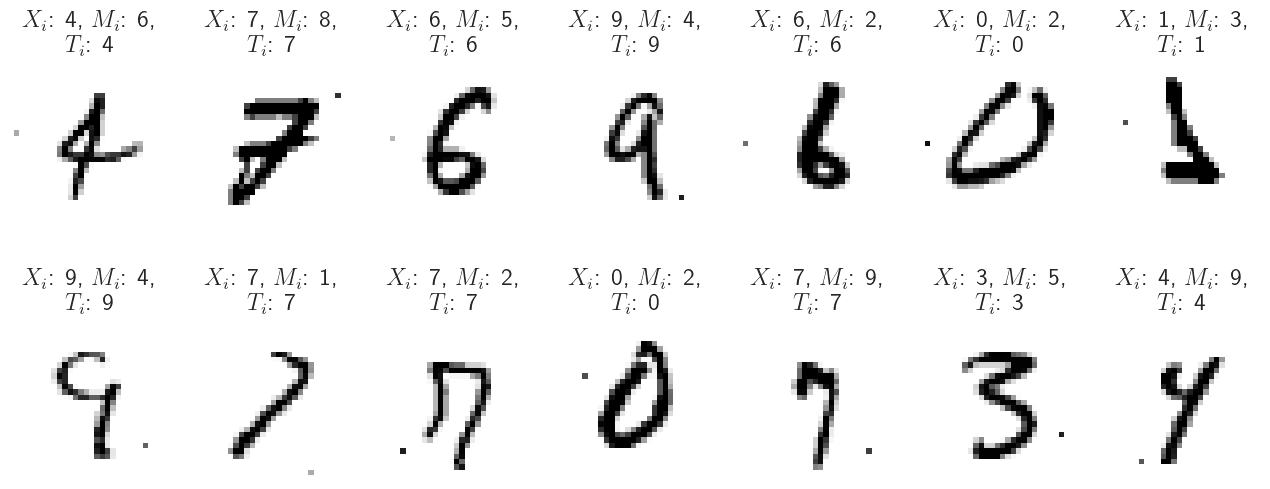

FloatProgress(value=0.0, max=125.0)

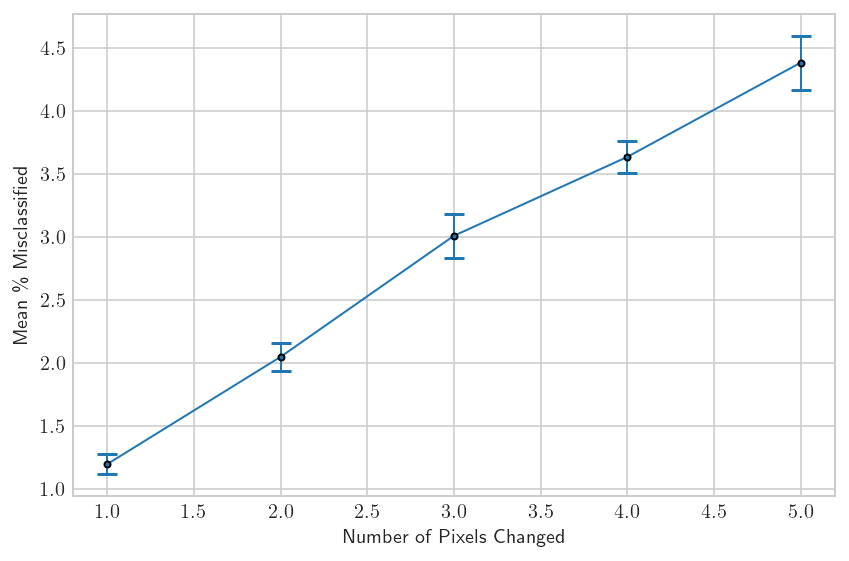

In [15]:
pixels_to_change = 1
Xcopy = per.change_pixel(Xtest, pixels_to_change=pixels_to_change)

diff_index, percent_diff = per.classified_diff(nnet, Xtest, Xcopy, Ttest)

print(f'''Total of {len(diff_index)} misclassified samples,
      with a {percent_diff:.3f}% difference from test by changing {pixels_to_change} pixel(s)''')

per.imshow(nnet, Xtest, Xcopy, Ttest, diff_index, model='MNIST', 
           name='media/mnist_example_1px.pdf')

per.change_in_pixels_plot(nnet, Xtest, Ttest, end_pixel_val=5, 
                          trials_per_pixel=25, errorbar=True, pertrub='stuck',
                          name='media/mnist_change_5px.pdf')

FloatProgress(value=0.0, max=250.0)

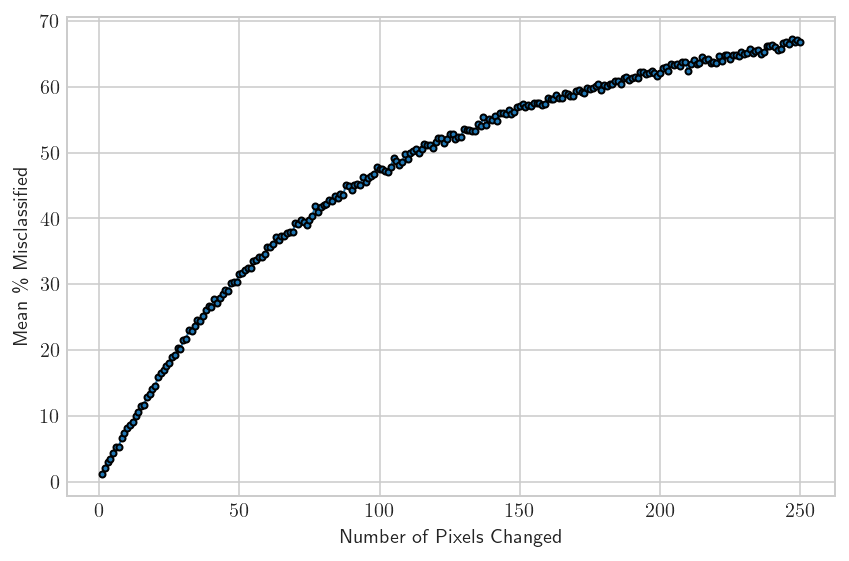

In [49]:
per.change_in_pixels_plot(nnet, Xtest, Ttest, end_pixel_val=250, 
                          trials_per_pixel=1, errorbar=False, pertrub='stuck',
                          name='media/mnist_change_overtime.pdf')